# RMSE for SCFG

In [7]:
from scripts.imports import *
from sklearn.metrics import root_mean_squared_error
pd.set_option('display.max_rows', None)

df = pd.read_pickle('five_sites_data_snow_cc.pkl')

df_grouped = df[df['SCFG'] <= 100].dropna().groupby(['camera', 'date', 'lat', 'lon']).agg({
    'SCFG': 'mean',  # Average the binary predictions
    'FSC': 'mean'
}).reset_index(drop=True)

print(root_mean_squared_error(df_grouped['FSC'], df_grouped['SCFG']/100))
print(df_grouped['FSC'].mean())
df_grouped['FSC_proximity'] = df_grouped['FSC'].apply(lambda x: 2 * min(abs(x - 0), abs(x - 1)))
print(df_grouped['FSC_proximity'].mean())
print()
print(root_mean_squared_error(df_grouped['FSC'], df_grouped['SCFG']/100)/df_grouped['FSC'].mean())
print(root_mean_squared_error(df_grouped['FSC'], df_grouped['SCFG']/100)/df_grouped['FSC_proximity'].mean())

0.12169290148190406
0.25888324873096447
0.08426395939086295

0.47006865866539416
1.4441868428876565


# How many data points from each site?

Index(['camera', 'date', 'lon', 'lat', 'Eg', 'Ev', 'EvEg', 'trad_cc', 'beam',
       'msw_flag', 'night_flag', 'asr', 'canopy_openness', 'snr',
       'segment_cover', 'segment_landcover', 'h_te_interp', 'h_te_std',
       'terrain_slope', 'longitude', 'latitude', 'FSC', 'TreeSnow', 'SCFG',
       'SCFV', 'cc'],
      dtype='object')
5533 5000 4133 2048 1364 5169
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23247 entries, 0 to 23246
Data columns (total 26 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   camera             23247 non-null  object 
 1   date               23247 non-null  object 
 2   lon                23247 non-null  float64
 3   lat                23247 non-null  float64
 4   Eg                 23247 non-null  float32
 5   Ev                 23247 non-null  float32
 6   EvEg               23246 non-null  float32
 7   trad_cc            23247 non-null  float64
 8   beam               23247 non-null  objec

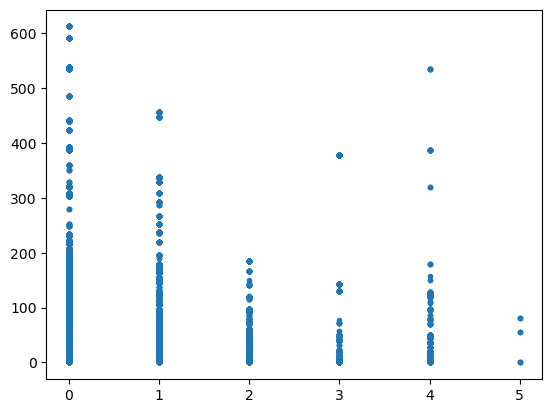

In [5]:
from scripts.imports import *
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report

df = pd.read_pickle('five_sites_data_snow_cc.pkl')
print(df.columns)
plt.plot(df['msw_flag'], df['snr'], '.')

X = df[['camera','Eg', 'Ev', 'msw_flag', 'asr', 'night_flag']]
# X = X.dropna()
# y = df['FSC']

print(X[X['camera']=='sodankyla_full'].shape[0],X[X['camera']=='delta_junction'].shape[0],X[X['camera']=='marcell_MN'].shape[0],X[X['camera']=='lacclair'].shape[0],X[X['camera']=='torgnon'].shape[0], X[X['camera']=='oregon_yp'].shape[0])

df.info()

# Random Forest (worse than NN)

In [20]:
# import pandas as pd
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.model_selection import LeaveOneGroupOut
# from sklearn.preprocessing import StandardScaler, OneHotEncoder
# from sklearn.compose import ColumnTransformer
# from sklearn.pipeline import Pipeline
# from sklearn.metrics import root_mean_squared_error
# import numpy as np

# # Load your dataset using pickle
# df = pd.read_pickle('five_sites_data_snow_cc.pkl')

# # Remove rows where the 'FSC' entry is missing
# df = df.dropna(subset=['FSC'])

# # Split into features (X) and target (y)
# X_train_full = df[df['camera'] != 'oregon_yp'].drop(columns=['FSC'])  # All training data except 'oregon_yp'
# y_train_full = df[df['camera'] != 'oregon_yp']['FSC']  # Target variable
# X_test = df[df['camera'] == 'oregon_yp'].drop(columns=['FSC'])  # Test data
# y_test = df[df['camera'] == 'oregon_yp']['FSC']  # Test target variable

# # Define groups based on the 'camera' column in X_train_full
# groups = X_train_full['camera']

# # Leave-one-site-out cross-validation using the 'camera' column as the group
# logo = LeaveOneGroupOut()

# # Define feature columns
# continuous_features = ['Eg', 'Ev', 'trad_cc', 'asr', 'canopy_openness', 
#                        'snr', 'segment_cover', 'h_te_std', 'terrain_slope']
# categorical_features = ['beam', 'msw_flag', 'night_flag']

# # Define the preprocessor for the pipeline
# preprocessor = ColumnTransformer(
#     transformers=[
#         ('num', StandardScaler(), continuous_features),
#         ('cat', OneHotEncoder(drop='first', handle_unknown='infrequent_if_exist'), categorical_features)
#     ])

# # Create a pipeline that applies the preprocessor then the classifier
# pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))])

# # Prepare to store results
# validation_rmse = []

# # Cross-validation loop
# for train_idx, val_idx in logo.split(X_train_full, y_train_full, groups):
#     # Get the training and validation data using the index from LOGO
#     X_tr, X_val = X_train_full.iloc[train_idx], X_train_full.iloc[val_idx]
#     y_tr, y_val = y_train_full.iloc[train_idx], y_train_full.iloc[val_idx]
    
#     # Identify the site (camera) used for validation
#     validation_site = X_val['camera'].unique()[0]  # Assuming only one unique camera per fold
    
#     # Only keep binary FSC values (0, 1) for training the model
#     binary_train_mask = y_tr.isin([0, 1])
#     X_tr_binary = X_tr[binary_train_mask]
#     y_tr_binary = y_tr[binary_train_mask]
    
#     # Fit the model (preprocessing + random forest) for the current fold
#     pipeline.fit(X_tr_binary, y_tr_binary)
    
#     # Validate the model (on both binary and non-binary values)
#     y_val_pred = pipeline.predict(X_val)
    
#     # Add predictions to validation set for aggregation
#     df_val = X_train_full.iloc[val_idx].copy()
#     df_val['binary_pred'] = y_val_pred
#     df_val['FSC'] = y_val.values  # Add actual FSC values
    
#     # Aggregate the results by 'camera', 'date', 'lat', 'lon'
#     df_val_grouped = df_val.groupby(['camera', 'date', 'lat', 'lon']).agg({
#         'binary_pred': 'mean',  # Average the binary predictions
#         'FSC': 'mean'  # Actual FSC, which can be non-binary
#     })
    
#     # Compute RMSE for the validation fold using root_mean_squared_error
#     rmse_val = root_mean_squared_error(df_val_grouped['FSC'], df_val_grouped['binary_pred'])
#     validation_rmse.append((validation_site, rmse_val))

# # After cross-validation, refit the model using the full training dataset (all sites except 'oregon_yp')
# binary_train_mask_full = y_train_full.isin([0, 1])
# X_train_binary_full = X_train_full[binary_train_mask_full]
# y_train_binary_full = y_train_full[binary_train_mask_full]

# # Refit the model using all available training data
# pipeline.fit(X_train_binary_full, y_train_binary_full)

# # Test the model on the test set ('oregon_yp')
# y_test_pred = pipeline.predict(X_test)

# # Add predictions to test set for aggregation
# df_test = X_test.copy()
# df_test['binary_pred'] = y_test_pred
# df_test['FSC'] = y_test.values  # Add actual FSC values

# # Aggregate the test results by 'camera', 'date', 'lat', 'lon'
# df_test_grouped = df_test.groupby(['camera', 'date', 'lat', 'lon']).agg({
#     'binary_pred': 'mean',  # Average the binary predictions
#     'FSC': 'mean'  # Actual FSC, which can be non-binary
# })

# # Compute RMSE for the test set using root_mean_squared_error
# rmse_test = root_mean_squared_error(df_test_grouped['FSC'], df_test_grouped['binary_pred'])

# # Display RMSE for each validation fold with site name
# for site, rmse in validation_rmse:
#     print(f"Validation RMSE for site {site}: {rmse}")

# # Display test RMSE
# # print(f"Test RMSE: {rmse_test}")


/scratch/s1803229/.conda/envs/snow_env/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Validation RMSE for site delta_junction: 0.33443919773163544
Validation RMSE for site lacclair: 0.30111122537622537
Validation RMSE for site marcell_MN: 0.4929317365616631
Validation RMSE for site sodankyla_full: 0.3699564802299785
Validation RMSE for site torgnon: 0.2753287763469651


# Neural Network

In [27]:
import pandas as pd
import numpy as np
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import root_mean_squared_error
import tensorflow as tf
from tensorflow.keras import layers, models

# Load your dataset using pickle
df = pd.read_pickle('five_sites_data_snow_cc.pkl')

# Remove rows where the 'FSC' entry is missing
df = df.dropna(subset=['FSC'])

# Split into features (X) and target (y)
X_train_full = df[df['camera'] != 'oregon_yp'].drop(columns=['FSC'])  # All training data except 'oregon_yp'
y_train_full = df[df['camera'] != 'oregon_yp']['FSC']  # Target variable
X_test = df[df['camera'] == 'oregon_yp'].drop(columns=['FSC'])  # Test data
y_test = df[df['camera'] == 'oregon_yp']['FSC']  # Test target variable

# Define groups based on the 'camera' column in X_train_full
groups = X_train_full['camera']

# Leave-one-site-out cross-validation using the 'camera' column as the group
logo = LeaveOneGroupOut()

# Define feature columns
continuous_features = ['Eg', 'Ev', 'trad_cc', 'asr', 'canopy_openness', 
                       'snr', 'segment_cover', 'h_te_std', 'terrain_slope']
categorical_features = ['beam', 'msw_flag', 'night_flag']

# Define the preprocessor for the pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), continuous_features),
        ('cat', OneHotEncoder(drop='first', handle_unknown='infrequent_if_exist'), categorical_features)
    ])

# Function to build a neural network model
def create_nn_model(input_dim):
    model = models.Sequential()
    model.add(layers.InputLayer(input_dim))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dense(1))  # Output layer for regression
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Prepare to store results
validation_rmse = []

# Cross-validation loop
for train_idx, val_idx in logo.split(X_train_full, y_train_full, groups):
    # Get the training and validation data using the index from LOGO
    X_tr, X_val = X_train_full.iloc[train_idx], X_train_full.iloc[val_idx]
    y_tr, y_val = y_train_full.iloc[train_idx], y_train_full.iloc[val_idx]
    
    # Identify the site (camera) used for validation
    validation_site = X_val['camera'].unique()[0]  # Assuming only one unique camera per fold
    
    # Preprocess the data
    X_tr_transformed = preprocessor.fit_transform(X_tr)
    X_val_transformed = preprocessor.transform(X_val)
    
    # Only keep binary FSC values (0, 1) for training the model
    binary_train_mask = y_tr.isin([0, 1])
    X_tr_binary = X_tr_transformed[binary_train_mask]
    y_tr_binary = y_tr[binary_train_mask]
    
    # Create and train the neural network
    nn_model = create_nn_model(X_tr_binary.shape[1])
    nn_model.fit(X_tr_binary, y_tr_binary, epochs=50, batch_size=32, verbose=0)
    
    # Validate the model (on both binary and non-binary values)
    y_val_pred = nn_model.predict(X_val_transformed).flatten()
    
    # Add predictions to validation set for aggregation
    df_val = X_train_full.iloc[val_idx].copy()
    df_val['binary_pred'] = y_val_pred
    df_val['FSC'] = y_val.values  # Add actual FSC values
    
    # Aggregate the results by 'camera', 'date', 'lat', 'lon'
    df_val_grouped = df_val.groupby(['camera', 'date', 'lat', 'lon']).agg({
        'binary_pred': 'mean',  # Average the binary predictions
        'FSC': 'mean'  # Actual FSC, which can be non-binary
    })
    
    # Compute RMSE for the validation fold
    rmse_val = root_mean_squared_error(df_val_grouped['FSC'], df_val_grouped['binary_pred'])
    validation_rmse.append((validation_site, rmse_val))

# After cross-validation, refit the model using the full training dataset (all sites except 'oregon_yp')
binary_train_mask_full = y_train_full.isin([0, 1])
X_train_binary_full = preprocessor.fit_transform(X_train_full[binary_train_mask_full])
y_train_binary_full = y_train_full[binary_train_mask_full]

# Refit the neural network using all available training data
nn_model_full = create_nn_model(X_train_binary_full.shape[1])
nn_model_full.fit(X_train_binary_full, y_train_binary_full, epochs=50, batch_size=32, verbose=0)

# Test the model on the test set ('oregon_yp')
X_test_transformed = preprocessor.transform(X_test)
y_test_pred = nn_model_full.predict(X_test_transformed).flatten()

# Add predictions to test set for aggregation
df_test = X_test.copy()
df_test['binary_pred'] = y_test_pred
df_test['FSC'] = y_test.values  # Add actual FSC values

# Aggregate the test results by 'camera', 'date', 'lat', 'lon'
df_test_grouped = df_test.groupby(['camera', 'date', 'lat', 'lon']).agg({
    'binary_pred': 'mean',  # Average the binary predictions
    'FSC': 'mean'  # Actual FSC, which can be non-binary
})

# Compute RMSE for the test set using root_mean_squared_error
rmse_test = root_mean_squared_error(df_test_grouped['FSC'], df_test_grouped['binary_pred'])

# Display RMSE for each validation fold with site name
for site, rmse in validation_rmse:
    print(f"Validation RMSE for site {site}: {rmse}")

# Display test RMSE
# print(f"Test RMSE: {rmse_test}")


173/173 [==============================] - 0s 514us/step


/scratch/s1803229/.conda/envs/snow_env/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


146/146 [==============================] - 0s 638us/step
Validation RMSE for site delta_junction: 0.2967584357812933
Validation RMSE for site lacclair: 0.2872689862677874
Validation RMSE for site marcell_MN: 0.44674600256209396
Validation RMSE for site sodankyla_full: 0.35488136490023103
Validation RMSE for site torgnon: 0.32251554869302007


# Parameter Tuner for Neural Network

In [23]:
import pandas as pd
import numpy as np
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import root_mean_squared_error
import tensorflow as tf
from tensorflow.keras import layers, models
from keras_tuner import Hyperband

# Load your dataset using pickle
df = pd.read_pickle('five_sites_data_snow_cc.pkl')

# Remove rows where the 'FSC' entry is missing
df = df.dropna(subset=['FSC'])

# Split into features (X) and target (y)
X_train_full = df[df['camera'] != 'oregon_yp'].drop(columns=['FSC'])  # All training data except 'oregon_yp'
y_train_full = df[df['camera'] != 'oregon_yp']['FSC']  # Target variable
X_test = df[df['camera'] == 'oregon_yp'].drop(columns=['FSC'])  # Test data
y_test = df[df['camera'] == 'oregon_yp']['FSC']  # Test target variable

# Define groups based on the 'camera' column in X_train_full
groups = X_train_full['camera']

# Leave-one-site-out cross-validation using the 'camera' column as the group
logo = LeaveOneGroupOut()

# Define feature columns
continuous_features = ['Eg', 'Ev', 'trad_cc', 'asr', 'canopy_openness', 
                       'snr', 'segment_cover', 'h_te_std', 'terrain_slope']
categorical_features = ['beam', 'msw_flag', 'night_flag']

# Define the preprocessor for the pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), continuous_features),
        ('cat', OneHotEncoder(drop='first', handle_unknown='infrequent_if_exist'), categorical_features)
    ])

# Function to build a neural network model
def build_model(hp, input_dim):
    model = models.Sequential()
    
    # Input layer with dynamic input dimension
    model.add(layers.InputLayer(input_shape=(input_dim,)))

    # Number of hidden layers
    for i in range(hp.Int('num_layers', 1, 4)):
        # Number of units per layer
        model.add(layers.Dense(units=hp.Int(f'units_{i}', min_value=32, max_value=256, step=32), activation='relu'))

    # Output layer for regression
    model.add(layers.Dense(1))
    
    # Compile the model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=hp.Float('learning_rate', 1e-4, 1e-2, sampling='log')),
        loss='mean_squared_error')
    
    return model

# Prepare the search strategy with Hyperband
tuner = Hyperband(
    lambda hp: build_model(hp, input_dim=None),  # Will set input_dim later after preprocessing
    objective='val_loss',  # Minimize validation loss (mean squared error)
    max_epochs=50,         # Maximum epochs for training
    factor=3,              # Factor by which to reduce the number of trials
    executions_per_trial=1, # Number of model evaluations per trial
    directory='my_tuner_dir',
    project_name='nn_hyperband_optimization'
)

# Prepare to store results
validation_rmse = []

# Cross-validation loop
for train_idx, val_idx in logo.split(X_train_full, y_train_full, groups):
    # Get the training and validation data using the index from LOGO
    X_tr, X_val = X_train_full.iloc[train_idx], X_train_full.iloc[val_idx]
    y_tr, y_val = y_train_full.iloc[train_idx], y_train_full.iloc[val_idx]
    
    # Identify the site (camera) used for validation
    validation_site = X_val['camera'].unique()[0]  # Assuming only one unique camera per fold
    
    # Preprocess the data
    X_tr_transformed = preprocessor.fit_transform(X_tr)
    X_val_transformed = preprocessor.transform(X_val)

    # Determine the correct input dimension after preprocessing
    input_dim = X_tr_transformed.shape[1]
    
    # Rebuild tuner with correct input dimension
    tuner.hypermodel = lambda hp: build_model(hp, input_dim=input_dim)

    # Only keep binary FSC values (0, 1) for training the model
    binary_train_mask = y_tr.isin([0, 1])
    X_tr_binary = X_tr_transformed[binary_train_mask]
    y_tr_binary = y_tr[binary_train_mask]
    
    # Search for the best model using Hyperband
    tuner.search(X_tr_binary, y_tr_binary, epochs=50, validation_data=(X_val_transformed, y_val), verbose=0)
    
    # Get the best model
    best_model = tuner.get_best_models(num_models=1)[0]
    
    # Validate the best model (on both binary and non-binary values)
    y_val_pred = best_model.predict(X_val_transformed).flatten()
    
    # Add predictions to validation set for aggregation
    df_val = X_train_full.iloc[val_idx].copy()
    df_val['binary_pred'] = y_val_pred
    df_val['FSC'] = y_val.values  # Add actual FSC values
    
    # Aggregate the results by 'camera', 'date', 'lat', 'lon'
    df_val_grouped = df_val.groupby(['camera', 'date', 'lat', 'lon']).agg({
        'binary_pred': 'mean',  # Average the binary predictions
        'FSC': 'mean'  # Actual FSC, which can be non-binary
    })
    
    # Compute RMSE for the validation fold
    rmse_val = root_mean_squared_error(df_val_grouped['FSC'], df_val_grouped['binary_pred'])
    validation_rmse.append((validation_site, rmse_val))

# Test the model on the test set ('oregon_yp')
X_test_transformed = preprocessor.transform(X_test)
y_test_pred = best_model.predict(X_test_transformed).flatten()

# Add predictions to test set for aggregation
df_test = X_test.copy()
df_test['binary_pred'] = y_test_pred
df_test['FSC'] = y_test.values  # Add actual FSC values

# Aggregate the test results by 'camera', 'date', 'lat', 'lon'
df_test_grouped = df_test.groupby(['camera', 'date', 'lat', 'lon']).agg({
    'binary_pred': 'mean',  # Average the binary predictions
    'FSC': 'mean'  # Actual FSC, which can be non-binary
})

# Compute RMSE for the test set using root_mean_squared_error
rmse_test = root_mean_squared_error(df_test_grouped['FSC'], df_test_grouped['binary_pred'])

# Display RMSE for each validation fold with site name
for site, rmse in validation_rmse:
    print(f"Validation RMSE for site {site}: {rmse}")

# Display test RMSE
print(f"Test RMSE: {rmse_test}")

# Get the best hyperparameters
best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]

# Print the best hyperparameters in a format for re-use
print("\nBest Hyperparameters:")
for param in best_hp.values:
    print(f"{param}: {best_hp.get(param)}")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.8 MB/s eta 0:00:00a 0:00:01
